<a href="https://colab.research.google.com/github/amirhoseinaghaei/Image-Captioning-/blob/main/Image_Captioning_For_Flicker_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
import numpy as np 
import pickle
import tensorflow as tf
from tensorflow.keras import models , Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tqdm import tqdm 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Conv2D , MaxPooling2D   , Flatten
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.model_selection import train_test_split 
from keras.callbacks import ModelCheckpoint , EarlyStopping


## Getting dataset from google drive

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
BASE_DIR = "gdrive/MyDrive/Flicker_Dataset"
WORKING_DIR  = "gdrive/MyDrive/Image_Captioning_Project "

Mounted at /content/gdrive/


## Load Flicker dataset images 

In [8]:
# Loading the flicker-dataset images and extracting featueres
from tqdm import tqdm
features = {}
images = {}
img_list = []
directory = os.path.join(BASE_DIR, "Images")
# with open(os.path.join(WORKING_DIR , "images.pkl"), "rb") as f:
#     images = pickle.load(f)
for img_name in tqdm(os.listdir(directory)):
  image_path = directory  + "/" + img_name
  image = load_img(image_path , target_size= (224,224))
  image = img_to_array(image) 
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  # feature = model.predict(image)
  # img_list.append(image)
  image_id = img_name.split(".")[0]
  images[image_id] = image
  # features[image_id]  = feature


KeyboardInterrupt: ignored

In [1]:
plt.imshow(images["3758787457_1a903ee1e9"][0])

NameError: ignored

In [4]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
  X1, X2, y = list(), list(), list()
  # walk through each image identifier
  for key, desc_list in descriptions.items():
    # walk through each description for the image
    for desc in desc_list:
      # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
         # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
    if key != "":
      X1.append((photos[key][0]))
      X2.append(in_seq)
      y.append(out_seq)
  return (X1), (X2), (y)

## Save the extracted Image 

In [5]:
# saving features dictionary in pkl file 
import pickle
pickle.dump(images , open(os.path.join(WORKING_DIR , "images.pkl"), "wb"))

## Loading Captions for each image

In [6]:
from IPython.utils.text import string
def load_captions(path):
  with open(path, 'r') as f: 
    next(f)
    captions = f.read()
  mapping = {}
  line = captions.split("\n")
  for i in line:
    splitted = i.split(",")
    if len(line) < 2:
      continue
    img_id = splitted[0].split(".")[0]
    # print(splitted[1])
    caption = splitted[1:]
    caption = " ".join(caption)
    if img_id not in mapping.keys():
      mapping[img_id] = []
    # print(image_id + ": " + caption)
    mapping[img_id].append(caption)
  return mapping
descriptions = load_captions(os.path.join(BASE_DIR, "captions.txt"))
def clean_Descriptions(descriptions):
  table = str.maketrans('','',string.punctuation)
  for key, value in descriptions.items():
    for i in range(len(value)):
      text = descriptions[key][i]
      text = text.lower()
      text = text.translate(str.maketrans('', '', string.punctuation))
      text = text.split()
      text = [ele for ele in text if len(ele) > 1]
      text = [ele for ele in text if (ele).isalpha()]
      text = ' '.join(text)
      descriptions[key][i] = text
  return descriptions
descriptions = clean_Descriptions(descriptions)

## Finding the vocabulary size of captions

In [ ]:
def Find_Vocab_Size(descriptions):
  Vocabulary = set()
  for key in descriptions.keys():
    for i in descriptions[key]:
      Vocabulary.update(i.split())
  return Vocabulary
vocab_size = (len(Find_Vocab_Size(descriptions)))

## Visualizing 10 images with their captions


In [ ]:
i = 0 
for img_name in tqdm(os.listdir(directory)):
  i += 1
  image_path = directory + "/" + img_name 
  image = mpimg.imread(image_path)
  print(f"\nImage : {img_name}")
  plt.imshow(image)
  print(f"{img_name}'s captions are as below:")
  image_id = img_name.split(".")[0]
  print(mapping[image_id])
  if i == 10: 
    break

## Defining the model

In [8]:
from tensorflow.python.keras.layers.merge import Add
from tensorflow.python.ops.gen_array_ops import InplaceAdd
from keras.backend import conv2d

from keras import optimizers
from tensorflow.python.ops.nn_ops import relu
def Build_CNN_FeatureExtractor(vocab_size):
      input1 = Input(shape=(128,128,3))
      conv1 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(input1)
      conv2 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(conv1)
      max1 =  MaxPooling2D((2,2), (2,2))(conv2)
      conv3 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(max1)
      conv4 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(conv3)
      max2 =  MaxPooling2D((2,2), (2,2))(conv4)
      conv5 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(max2)
      conv6 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv5)
      conv7 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv6)
      max3 =  MaxPooling2D((2,2), (2,2))(conv7)
      conv8 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max3)
      conv9 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv8)
      conv10 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv9)
      max4 =  MaxPooling2D((2,2), (2,2))(conv10)
      conv11 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max4)
      conv12 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv11)
      conv13 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv12)
      max5 =  MaxPooling2D((2,2), (2,2))(conv13)
      flatten = Flatten()(max5)
      dense1 = Dense(4096, activation = tf.nn.relu)(flatten)
      dropout1 = Dropout(0.4)(dense1)
      dense2 = Dense(4096)(dropout1)
      dense3 = Dense(256)(dense2)
      input2 = Input(shape = (32,))
      embedding = Embedding(input_dim = vocab_size, output_dim = 256)(input2)
      dropout2 = Dropout(0.4)(embedding)
      lstm = LSTM(256)(dropout2)
      added = add([dense3, lstm])
      dense4 = Dense(256 , activation = tf.nn.relu)(added)
      output = Dense(vocab_size, activation = tf.nn.softmax)(dense4)
      model = Model(inputs = [input1 , input2], outputs = output)
      return model
 
vocab_size = 8765
model = Build_CNN_FeatureExtractor(vocab_size)
optimizer = tf.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy" , metrics = ["Accuracy"] )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_13[0][0]']              
                                )                                                           

## Plotting the model

In [45]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc


In [46]:
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
X1, X2, y = create_sequences(tokenizer, max_length(descriptions), descriptions, images, vocab_size + 1)


In [73]:
Images , Captions, Outputs = np.array(X1), np.array(X2), np.array(y)

In [48]:
X_train1 = Images[0:7000]
X_train2 = Captions[0:7000]
Y_train = Outputs[0:7000]
X_test1 = Images[7000:8091]
X_test2 = Captions[7000:8091]
Y_test = Outputs[7000:8091]
X_val1 = X_train1[5000:6000]
X_val2 = X_train2[5000:6000]
Y_val = Y_train[5000:6000]

In [49]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=50)

# fit model
history = model.fit([X_train1, X_train2], Y_train, epochs=35, verbose=1, callbacks=[checkpoint, early_stop], validation_data=([X_val1, X_val2], Y_val))

Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 8.6159 - Accuracy: 0.0329
Epoch 1: val_loss improved from inf to 6.09662, saving model to model-ep001-loss8.616-val_loss6.097.h5
219/219 [==============================] - 29s 93ms/step - loss: 8.6159 - Accuracy: 0.0329 - val_loss: 6.0966 - val_Accuracy: 0.0340
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 6.0391 - Accuracy: 0.0340
Epoch 2: val_loss improved from 6.09662 to 5.82918, saving model to model-ep002-loss6.039-val_loss5.829.h5
219/219 [==============================] - 17s 78ms/step - loss: 6.0391 - Accuracy: 0.0340 - val_loss: 5.8292 - val_Accuracy: 0.0340
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 5.7822 - Accuracy: 0.0451
Epoch 3: val_loss improved from 5.82918 to 5.57737, saving model to model-ep003-loss5.782-val_loss5.577.h5
219/219 [==============================] - 17s 77ms/step - loss: 5.7822 - Accuracy: 0.0451 - val_loss: 5.5774 - val_Accuracy: 0.0

KeyboardInterrupt: ignored

In [84]:
_, accuracy = model.evaluate([X_test1,X_test2], Y_test)
print(f"Model accuracy is : {accuracy}")

35/35 [==============================] - 1s 22ms/step - loss: 9.6699 - Accuracy: 0.1806
Model accuracy is : 0.18056829273700714


In [86]:
res = model.predict([X_test1,X_test2])

35/35 [==============================] - 1s 16ms/step


In [190]:
def generate_desc(model, tokenizer, photo, max_length):
 photo = photo[np.newaxis, :, :, :]

 in_text = "start"
 for i in range(max_length):

   sequence = tokenizer.texts_to_sequences([in_text])[0]
   sequence = pad_sequences([sequence], maxlen=max_length)
   yhat = model.predict([photo,sequence])
   yhat = np.argmax(yhat)
   word = word_for_id(yhat, tokenizer)
   if word is None:
     break
   in_text += ' ' + word
   if word == 'endseq':
     break
 return in_text


In [176]:

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None


In [193]:
res = generate_desc(model, tokenizer, X_train1[1000], 32)
print(res)

1/1 [==============================] - 0s 25ms/step
start bike mural building mural structure outside building building crowd bag glasses underbrush falls her hand lights pole bride prizes fish hose bleachers them him outstretched pole bride headphones gontaga jeans headphones cape


In [187]:
print(res)

start bike mural building mural structure outside building building crowd bag glasses underbrush falls her hand lights pole bride prizes fish hose bleachers them him outstretched pole bride headphones gontaga jeans headphones cape


In [188]:
_, accuracy = model.evaluate([X_val1,X_val2], Y_val)
print(f"Model accuracy is : {accuracy}")

32/32 [==============================] - 1s 20ms/step - loss: 0.9423 - Accuracy: 0.7410
Model accuracy is : 0.7409999966621399


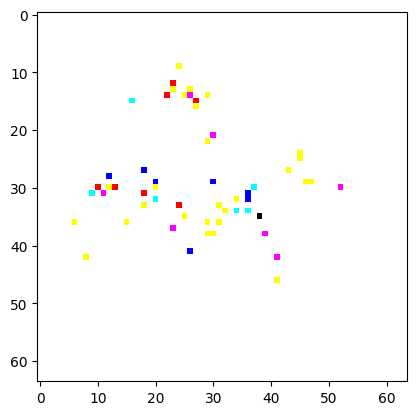

In [189]:
plt.imshow(X_test1[0])